# Equation of State Curve Compression

In [1]:
import os
import mendeleev
import numpy as np
from matplotlib import pyplot as plt

### Plotting and Utility Functions

In [41]:
def color(z):
    k = 2 * np.pi * z / 240
    return (1 + np.asarray([np.sin(k), np.sin(k + 2 * np.pi / 3), np.sin(k + 4 * np.pi / 3)], dtype=float)) / 2


def SMA_smooth(x_data, y_data, k=10):
    n = len(x_data)
    smooth_y_data = [None for _ in range(k, n - k)]
    for i in range(k, n - k):
        neighbors = np.arange(i - k, i + k + 1)
        smooth_y_data[i - k] = np.mean(y_data[neighbors])
    return np.array([x_data[k:n - k], smooth_y_data]).T


def gaussian_smooth(x_data, y_data, k=25):
    sd = np.mean(np.diff(x_data)) / 2
    var = sd * sd

    n = len(x_data)
    smooth_y_data = [None for _ in range(k, n - k)]
    for i in range(k, n - k):
        neighbors = np.arange(i - k, i + k + 1)
        kernel = np.exp(-np.square(x_data[neighbors] - x_data[i]) / var)
        kernel /= np.sum(kernel)
        smooth_y_data[i - k] = kernel @ y_data[neighbors]
    return np.array([x_data[k:n - k], smooth_y_data]).T

def interpolate(data, k):
    index = np.searchsorted(data[:, 0], k)
    dx = data[index, 0] - data[index - 1, 0]
    dy = data[index, 1] - data[index - 1, 1]
    return data[index - 1, 1] + (k - data[index - 1, 0]) * (dy / dx)

def clip_negative(data):
    for i in range(len(data) - 1, -1, -1):
        if data[i, 1] <= 0:
            break
    return data[i + 2:]

In [20]:
AMU = 1.66054e-27
PLANCK = 6.62607004e-34

noble_gases = ['He', 'Ne', 'Ar', 'Kr', 'Xe']
alkaline_metals = ['H', 'Li', 'Cs', 'Fr']
halogens = ['H', 'F', 'Cl', 'I']

# Thomas-Fermi Model Normalization

To gain an intuition of how we should normalize the $x$-axis, we first look at the Thomas-Fermi data, which is more well behaved and will more easily collapse.

In [21]:
TF_element_list = []
for file in os.listdir('Pressure Data/Thomas-Fermi Data'):
    element_name = file[:file.index('_')]

    if hasattr(mendeleev, element_name):
        element = getattr(mendeleev, element_name)
    else:
        continue

    tf_data = np.loadtxt(f'Pressure Data/Thomas-Fermi Data/{file}', dtype=float)
    log_tf_data = SMA_smooth(*np.log(tf_data[:11500], dtype=float).T)

    TF_element_list.append((element, log_tf_data))

TF_element_list.sort(key=lambda e: e[0].mass)

Throughout this analysis, a key technique is to analyze the logarithmic derivative, i.e. the derivative of a function's logarithm. The motivation for this is that we suspect the underlying form might be $P(E, \rho) = \mathcal{C}_E \cdot \mathcal{P}(f_E(\rho))$ for some constant $\mathcal{C}_E$ that depends on the element, and some transformation $f_E$ on the density $\rho$ that also depends on the element. To remove the constant, we can take the logarithm to convert $\mathcal{C}_E$ into an additional constant $+ \log\mathcal{C}_E$ and take the derivative to remove it. Another interpretation is that scaling a function also scales its derivative, so dividing the derivative $f'$ by the original function $f$ is invariant to scaling and $\frac{1}{f}\partial f = \partial\log f$.

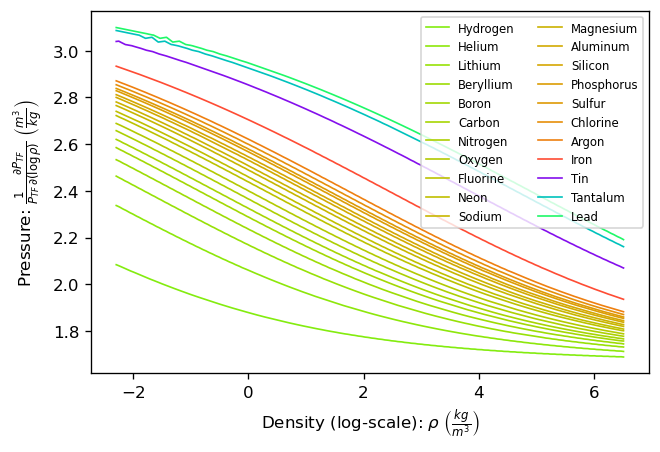

In [22]:
plt.figure(dpi=120)
for e, p in TF_element_list:
    plt.plot(p[:-1, 0], np.diff(p[:, 1], 1) / np.diff(p[:, 0], 1), color=color(e.mass), linewidth=1, label=e.name)

plt.xlabel(r'Density (log-scale): $\rho$ $\left(\frac{kg}{m^3}\right)$')
plt.ylabel(r'Pressure: $\frac{1}{P_{TF}} \frac{\partial P_{TF}}{\partial (\log\rho)}$ $\left(\frac{m^3}{kg}\right)$')
plt.legend(ncol=2, fontsize=7)
plt.show()

The curves above seem reasonably susceptible to collapse with an $x$-axis shift. Sure enough, normalizing the density by dividing by the atomic mass $m$ and the atomic number $z$, i.e. $\rho / (m \cdot z)$ collapses the log-derivative cleanly. Keep in mind that although the atomic number is unit-less, its meaning still corresponds to charge, so it has pseudo-units of Coulombs, denoted $C'$.

The actual motivation for why we divide by $m \cdot z$ specifically will be shown later. We will see that there is strong reason to divide by the mass when analyzing the hydrogen isotopes which do not differ in atomic number, and $z$ is used to recover the rest of the difference. Even though atomic number and atomic mass have a somewhat linear relationship, the relation is not precise enough for any other combinations to yield nearly as clean a collapse.

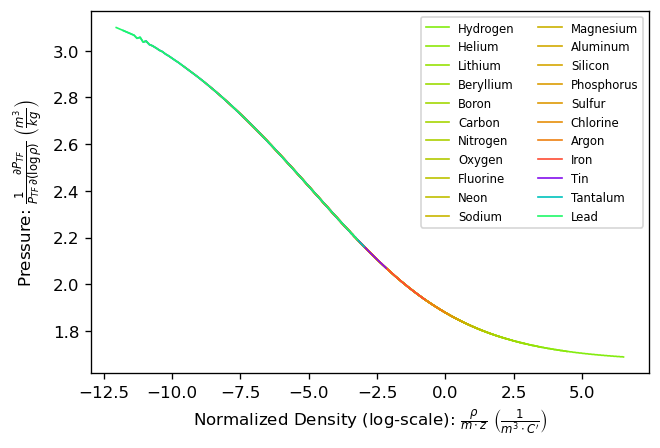

In [23]:
plt.figure(dpi=120)
for e, p in TF_element_list:
    x_data = p[:, 0] - np.log(e.atomic_number * e.mass)
    y_data = p[:, 1]
    plt.plot(x_data[:-1], np.diff(y_data, 1) / np.diff(x_data, 1), color=color(e.mass), linewidth=1, label=e.name)

plt.xlabel(r"Normalized Density (log-scale): $\frac{\rho}{m \cdot z}$ $\left(\frac{1}{m^3 \cdot C'}\right)$")
plt.ylabel(r'Pressure: $\frac{1}{P_{TF}} \frac{\partial P_{TF}}{\partial (\log\rho)}$ $\left(\frac{m^3}{kg}\right)$')
plt.legend(ncol=2, fontsize=7)
plt.show()

Therefore, we have the equation $$\begin{align*}
                    & \frac{1}{P_{TF}} \frac{\partial P_{TF}(E, \rho)}{\partial (\log\rho)} = \mathcal{P}_{TF}^*(\log\rho - \log(m_E \cdot z_E))   \\
    \Rightarrow\    & P_{TF}(E, \rho) = \mathcal{C}_E \cdot \mathcal{P}_{TF}^*\left(\frac{\rho}{m_E \cdot z_E}\right)
\end{align*}$$ for some function $\mathcal{P}_{TF}^*$ and constant $\mathcal{C}_E$ that is dependent on the element. It can be seen by trial and error, and visual inspection that $\mathcal{C}_E \propto z_E^{10 / 3}$ across all elements.

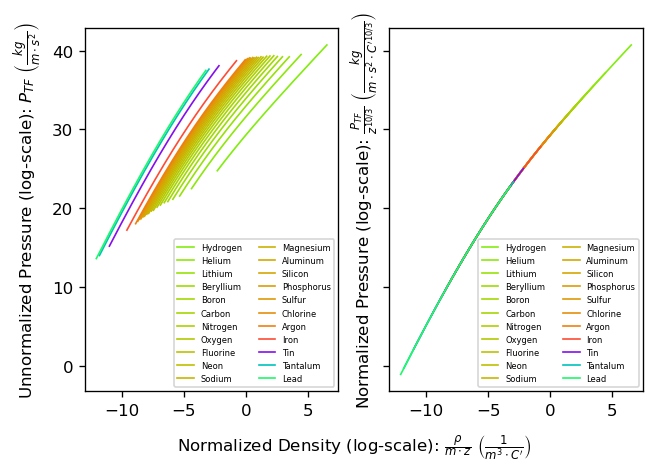

In [24]:
fig, (unnormalized, normalized) = plt.subplots(1, 2, sharey=True)
fig.dpi = 120

normalized_TF_dataset = []
for e, p in TF_element_list:
    x_data = p[:, 0] - np.log(e.atomic_number * e.mass)
    unnormalized_y_data = p[:, 1]
    normalized_y_data = unnormalized_y_data - np.log(e.atomic_number) * 10 / 3

    unnormalized.plot(x_data, unnormalized_y_data, color=color(e.mass), linewidth=1, label=e.name)
    normalized.plot(x_data, normalized_y_data, color=color(e.mass), linewidth=1, label=e.name)

    normalized_TF_dataset.extend(np.array([x_data, normalized_y_data]).T)

normalized_TF_dataset.sort(key=lambda p: p[0])
normalized_TF_dataset = SMA_smooth(*np.array(normalized_TF_dataset).T)

fig.text(0.5, 0, r"Normalized Density (log-scale): $\frac{\rho}{m \cdot z}$ $\left(\frac{1}{m^3 \cdot C'}\right)$", ha='center')

unnormalized.set_ylabel(r'Unnormalized Pressure (log-scale): $P_{TF}$ $\left(\frac{kg}{m \cdot s^2}\right)$')
unnormalized.legend(ncol=2, fontsize=5)

normalized.set_ylabel(r"Normalized Pressure (log-scale): $\frac{P_{TF}}{z^{10 / 3}}$ $\left(\frac{kg}{m \cdot s^2 \cdot C'^{10 / 3}}\right)$")
normalized.legend(ncol=2, fontsize=5)

plt.show()

Our final collapsed form for the Thomas-Fermi dataset is then $$
    P(E, \rho)= z_E^{10 / 3} \cdot \mathcal{P^*}\left(\frac{\rho}{m_E \cdot z_E}\right)
$$ for some function $\mathcal{P^*}$ that is independent of the element.

In [25]:
def p_star(k):
    index = np.searchsorted(normalized_TF_dataset[:, 0], k)
    dx = normalized_TF_dataset[index, 0] - normalized_TF_dataset[index - 1, 0]
    dy = normalized_TF_dataset[index, 1] - normalized_TF_dataset[index - 1, 1]
    return normalized_TF_dataset[index - 1, 1] + (k - normalized_TF_dataset[index - 1, 0]) * (dy / dx)

# Purgatorio Model Normalization

In [26]:
orbitals = [
    None, (1, 's'), (2, 's'), (2, 'p'), (3, 's'), (3, 'p'), (4, 's'), (3, 'd'), (4, 'p'), (5, 's'), (4, 'd'), (5, 'p'), (6, 's'), (4, 'f'), (5, 'd'), (6, 'p'), (7, 's')
]
orbital_map = {}

In [44]:
purg_element_list = []
for element_name in os.listdir('Elements'):
    element = None
    if element_name == 'D':
        element = mendeleev.H.isotopes[1]
        element.vdw_radius = 50.0
        element.ec = mendeleev.H.ec
        element.name = 'Deuterium'
        element.symbol = 'D'
    elif element_name == 'T':
        element = mendeleev.H.isotopes[2]
        element.vdw_radius = 40.0
        element.mass = 3.016
        element.ec = mendeleev.H.ec
        element.name = 'Tritium'
        element.symbol = 'T'
    elif hasattr(mendeleev, element_name):
        element = getattr(mendeleev, element_name)
    else:
        continue
    orbital = orbitals[len(element.ec._conf)]
    if orbital in orbital_map:
        orbital_map[orbital].append(element)
    else:
        orbital_map[orbital] = [element]

    purg_data = clip_negative(np.loadtxt(f'Elements/{element_name}/{element_name}.purgv157_rho_pcgs.dat.fix', dtype=float))
    log_purg_data = SMA_smooth(*np.log(purg_data).T)

    bulk_data = clip_negative(np.loadtxt(f'Elements/{element_name}/Bulk_Test_{element_name}.dat'))
    bulk_prime_data = np.loadtxt(f'Elements/{element_name}/BulkPrime_Test_{element_name}.dat')[-len(bulk_data):]

    purg_element_list.append((element, log_purg_data, bulk_data, bulk_prime_data))

for elements in orbital_map.values():
    elements.sort(key=lambda e: e.mass)

purg_element_list.sort(key=lambda e: e[0].mass)

First, we take a look at the three isotopes Hydrogen, Deuterium, and Tritium. Note that they appear to be shifted versions of each other, with the heavier isotopes occurring to the right. Furthermore, the $x$-axis is density, which motivates dividing by atomic mass.

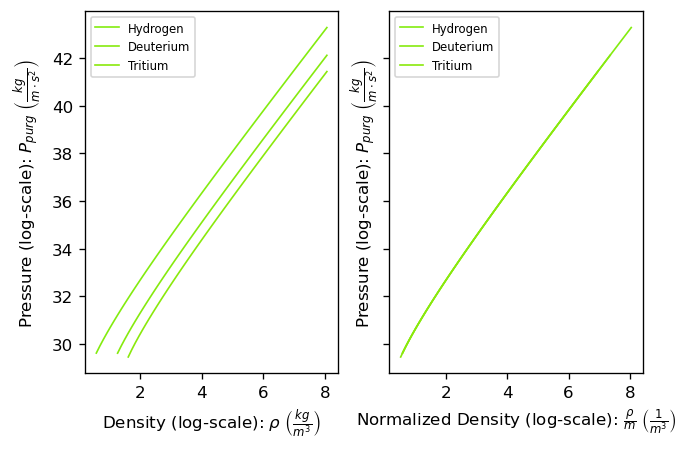

In [45]:
fig, (unnormalized, normalized) = plt.subplots(1, 2, sharey=True)
fig.dpi = 120
for e, p, b, bp in purg_element_list[:3]:
    unnormalized.plot(*p.T, color=color(e.mass), linewidth=1, label=e.name)
    normalized.plot(p[:, 0] - np.log(e.mass), p[:, 1], color=color(e.mass), linewidth=1, label=e.name)

unnormalized.set_xlabel(r'Density (log-scale): $\rho$ $\left(\frac{kg}{m^3}\right)$')
unnormalized.set_ylabel(r'Pressure (log-scale): $P_{purg}$ $\left(\frac{kg}{m \cdot s^2}\right)$')
unnormalized.legend(fontsize=7)

normalized.set_xlabel(r'Normalized Density (log-scale): $\frac{\rho}{m}$ $\left(\frac{1}{m^3}\right)$')
normalized.set_ylabel(r'Pressure (log-scale): $P_{purg}$ $\left(\frac{kg}{m \cdot s^2}\right)$')
normalized.legend(fontsize=7)

plt.show()

Note that the plots above are not of the logarithmic derivative, but of pressure itself. However, we have successfully collapsed the pressure curve with mass alone, and since Hydrogen, Deuterium, and Tritium do not differ by atomic number, this strongly suggests there is nothing else to be done with atomic mass, which is the motivation for the Thomas-Fermi normalization above.

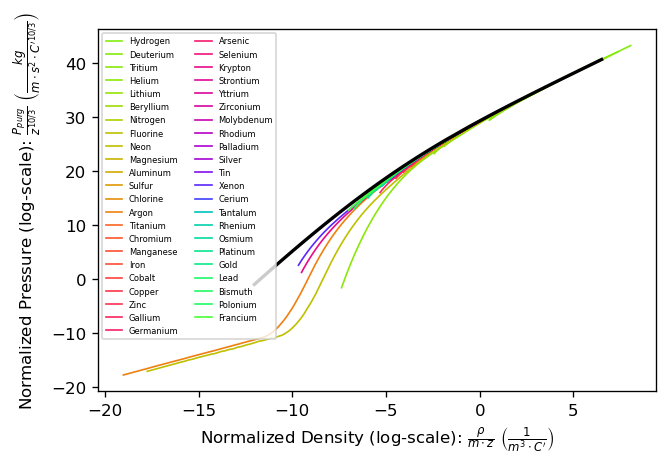

In [46]:
plt.figure(dpi=120)
for e, p, b, bp in purg_element_list:
    plt.plot(p[:, 0] - np.log(e.atomic_number * e.mass), p[:, 1] - np.log(e.atomic_number) * 10 / 3, color=color(e.mass), linewidth=1, label=e.name)

plt.plot(*normalized_TF_dataset.T, color='black', linewidth=2)

plt.xlabel(r"Normalized Density (log-scale): $\frac{\rho}{m \cdot z}$ $\left(\frac{1}{m^3 \cdot C'}\right)$")
plt.ylabel(r"Normalized Pressure (log-scale): $\frac{P_{purg}}{z^{10 / 3}}$ $\left(\frac{kg}{m \cdot s^2 \cdot C'^{10 / 3}}\right)$")

plt.legend(ncol=2, fontsize=5)
plt.show()

The white line above is a plot of the collapsed Thomas-Fermi data. As seen, the Purgatorio data is much less susceptible to collapse that of Thomas-Fermi. The first idea that comes to mind is normalizing by the Thomas-Fermi data itself, i.e. $P_{Purgatorio} / P_{Thomas-Fermi}$, which is equivalent to subtracting on the log-scale. This will help magnify the deviations that still remain and allow us to analyze them more closely. For ease of analysis, we will analyze $\log\left(\frac{P_{Thomas-Fermi}}{P_{Purgatorio}}\right)$ since positive values are open to more possibilities.

One slight problem is that even the total combined Thomas-Fermi data does not span a sufficiently large domain, so we will be required to clip some of the data in order to perform the normalization.

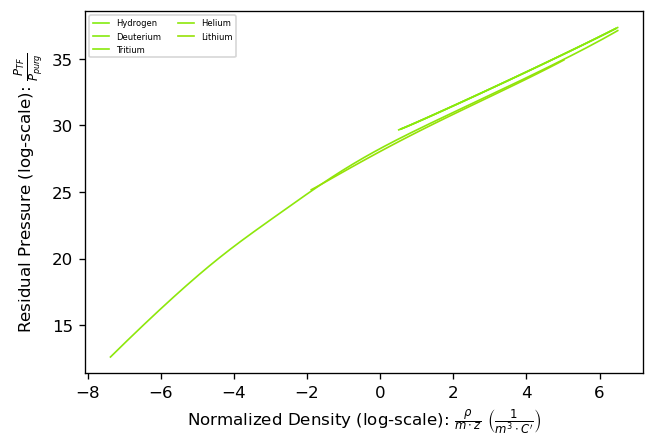

In [62]:
plt.figure(dpi=120)

residual_list = []
for e, p, b, bp in purg_element_list[:5]:
    x_data = p[:, 0] - np.log(e.atomic_number * e.mass)

    lo, hi = np.searchsorted(x_data, [normalized_TF_dataset[0, 0], normalized_TF_dataset[-1, 0]])
    x_data = p[lo:hi, 0] - np.log(e.atomic_number * e.mass)
    # y_data = (p[lo:hi, 1] - np.log(e.atomic_number) * 10 / 3) - p_star(x_data)
    y_data = np.log(np.exp(p_star(x_data)) - np.exp(p[lo:hi, 1] - np.log(e.atomic_number) * 10 / 3))

    b_data = interpolate(np.log(b), x_data)

    residual_list.append((e, np.array([p[lo:hi, 0], y_data]).T))

    plt.plot(x_data, y_data, color=color(e.mass), linewidth=1, label=e.name)
    # plt.plot(x_data, b_data, color=color(e.mass) / 2, linewidth=1, label=e.name)

plt.xlabel(r"Normalized Density (log-scale): $\frac{\rho}{m \cdot z}$ $\left(\frac{1}{m^3 \cdot C'}\right)$")
plt.ylabel(r"Residual Pressure (log-scale): $\frac{P_{TF}}{P_{purg}}$")

plt.legend(ncol=2, fontsize=5)
plt.show()

The fact that none of the curves ever go below $0$, i.e. that actual pressure never exceeds ideal pressure, and convergence to $0$ at infinity suggest that there is some exponential decay factor in play here, such as a Gaussian or exponential convolution. Because dividing the density by atomic mass aligns the Hydrogen isotopes, we have reason to believe that doing so is still useful, however, beyond Thomas-Fermi normalization there is no such reason for dividing by the atomic number. Therefore, we will reset the $x$-axis shift to $\rho / m$ and begin our analysis from there.

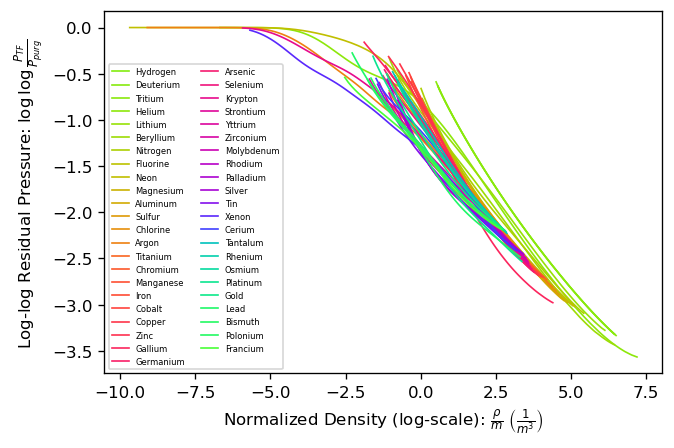

In [54]:
residual_map = {e.symbol: (e, r) for e, r in residual_list}

plt.figure(dpi=120)

# target = residual_list
# target = map(lambda e: residual_map[e.symbol], orbital_map[(4, 'f')])

for e, r in residual_list:
    plt.plot(r[:, 0] - np.log(e.mass), np.log(1 - np.exp(r[:, 1])), color=color(e.mass), linewidth=1, label=e.name)

plt.xlabel(r"Normalized Density (log-scale): $\frac{\rho}{m}$ $\left(\frac{1}{m^3}\right)$")
plt.ylabel(r"Log-log Residual Pressure: $\log\log\frac{P_{TF}}{P_{purg}}$")

plt.legend(ncol=2, fontsize=5)
plt.show()